In [304]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, optimize
#v. 20221209.1

filedir = './data/frog-rod/'
outputdir = './output/frog-rod/'

# файлы, перечисленные в строках, склеиваются
# каждая строка - это сигнал
# проводится усреднение (сигналы складываются и сумма делится на количество строк)
filenames = [['35.ASC'],
             ['36.ASC'],
             ['37.ASC'],
             ['38.ASC'],
             ['39.ASC'],
            ]
fs = 500                        # частота дискретизации, Гц
signal_scale = 1                # коэффициент масштабирования сигнала
signal_unit = 'pA'              # единица измерения сигнала
first_stim_start_time = 1       # начало первого стимула, с
period = 8                      # период следования стимулов, с
background_start_time = 5       # начало фоновой засветки, с
background_duration = 60        # длительность фоновой засветки, с
sign = -1                        # полярность {1:'стимулы вверх', -1:'стимулы вниз'}
stims_to_delete = []            # номера неудачных стимулов (перечислить через запятую)
stims_to_export = []            # номера стимулов для экспорта в файл (пример: [(0, 2), 25] - с 0 по 2, 25)
stims_on_exp_cnt = 2            # количество стимулов, участвующих в аппроксимации нисходящей экспоненты после окончания засветки
first_segment_on_exp = []       # первый отрезок, использующийся для аппроксимации экспоненты после выключения засветки (пример [41, 43]), с
# начало первого импульса после фоновой засветки
after_background_start_time = first_stim_start_time + ((background_start_time + background_duration - first_stim_start_time) // period + 1) * period
background_end_time = background_start_time + background_duration

In [305]:
# Чтение сигнала из файла(ов)

# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

signals = []
for row in filenames:
    signal = []
    filesizes = [] # количество точек в файлах
    for filename in row:
        with open(filedir + filename, 'r', encoding='utf-8') as file:
            filesizes.append(0)
            file.readline()
            line = file.readline()
            while line and line[0] == '"':
                line = file.readline()
            signal.append(sign * signal_scale * float('0' if line == '.\n' else line))
            filesizes[-1] += 1
            for line in file:
                signal.append(sign * signal_scale * float('0' if line == '.\n' else line))
                filesizes[-1] += 1
    signal = np.array(signal)
    # signal = moving_average(signal, 50)
    signals.append(signal)
signal = np.mean(signals, axis=0)

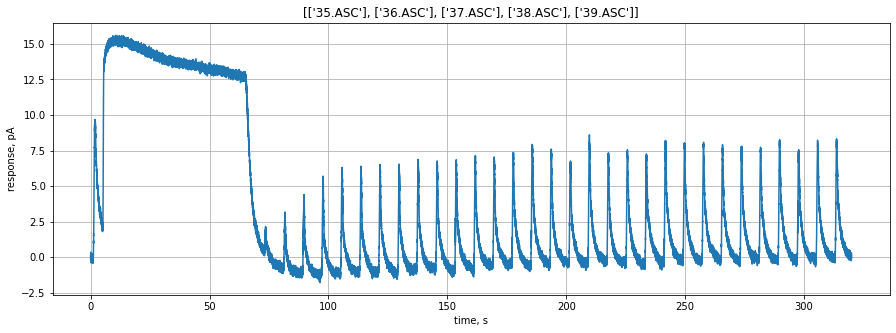

In [306]:
# Построение графика сигнала

n = signal.size
t = np.linspace(0, (n - 1) / fs, n)
fig, ax = plt.subplots()
ax.plot(t, signal)
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(filenames)
ax.grid()

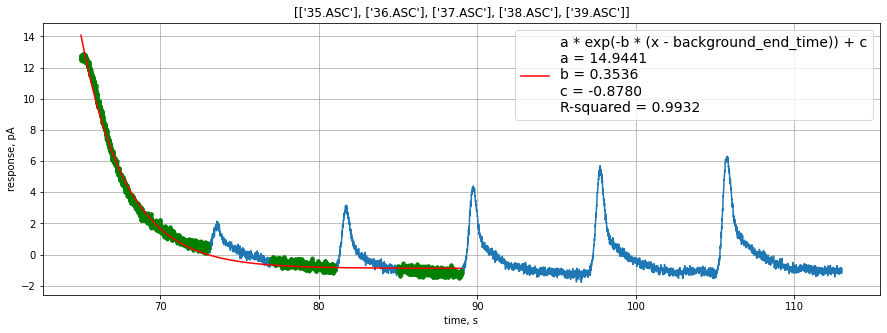

In [307]:
# Расчет нисходящей экспоненты
size = period // 2 * fs # хвост стимула - половина периода

# Для аппроксимации используется по умолчанию группа точек после конца засветки до after_background_start_time
# или группа точек из вручную указанного диапазона first_segment_on_exp
if not first_segment_on_exp:
    begin = background_end_time * fs
    end = after_background_start_time * fs
else:
    begin = first_segment_on_exp[0] * fs
    end = first_segment_on_exp[1] * fs
xs = [t[begin:end]]
ys = [signal[begin:end]]

# и еще stims_on_exp_cnt групп точек из хвостов stims_on_exp_cnt первых стимулов
begin = after_background_start_time * fs + period * fs - size
end = begin + size
for i in range(stims_on_exp_cnt):
    if begin > xs[0][-1] * fs: # если нет наложения на первую группу точек
        xs.append(t[begin:end])
        ys.append(signal[begin:end])
    begin += period * fs
    end = begin + size
x = np.concatenate(xs)
y = np.concatenate(ys)

# Аппроксимация нисходящей экспоненты
def func(x, a, b, c):
    return a * np.exp(-b * (x - background_end_time)) + c
popt = (1, 1, 1)
try:
    popt, pcov = optimize.curve_fit(func, x, y, [10, 0.2, 0])
except RuntimeError:
    print('Не удалось выполнить аппроксимацию нисходящей экспоненты. Подберите начальные коэффициенты.')
exp_a = popt[0]
exp_b = popt[1]
exp_c = popt[2]
begin = background_end_time * fs
end = after_background_start_time * fs + stims_on_exp_cnt * period * fs
exponent = func(t[begin:end], *popt)
rvalue = stats.linregress(y, func(x, *popt)).rvalue
r_squared = rvalue ** 2

fig, ax = plt.subplots()
ax.plot(t[begin:end + 3 * period * fs], signal[begin:end + 3 * period * fs]) # кроме экспоненты еще три периода для красоты графика
ax.plot(x, y, 'g.')
label = f'''a * exp(-b * (x - background_end_time)) + c
a = {exp_a:.4f}
b = {exp_b:.4f}
c = {exp_c:.4f}
R-squared = {r_squared:.4f}'''
if not first_segment_on_exp:
    ax.plot(t[begin:end], exponent, 'r', label=label)
else:
    begin = first_segment_on_exp[0] * fs
    begin1 = first_segment_on_exp[0] * fs - background_end_time * fs
    ax.plot(t[begin:end], exponent[begin1:end], 'r', label=label)
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(filenames)
ax.legend(prop={"size": 14})
ax.grid()

In [308]:
# Расчет количества и позиций стимулов

# Последний стимул в каждом файле исключается, так как нет гарантии, что длина файла будет кратна периоду стимулов.
# Если длина файла не кратна периоду, то последний стимул может быть обрезан концом файла.
stims_cnt = (filesizes[0] // fs - after_background_start_time) // period
begin = after_background_start_time
stims_t = []
for i in range(stims_cnt):
    stims_t.append(begin + i * period)
pos = 0
for i in range(1, len(filesizes)):
    file_stims_cnt = (filesizes[i] // fs - first_stim_start_time) // period
    stims_cnt += file_stims_cnt
    pos += filesizes[i - 1] // fs
    begin = pos + first_stim_start_time
    for j in range(file_stims_cnt):
        stims_t.append(begin + j * period)
stims_t = np.array(stims_t)

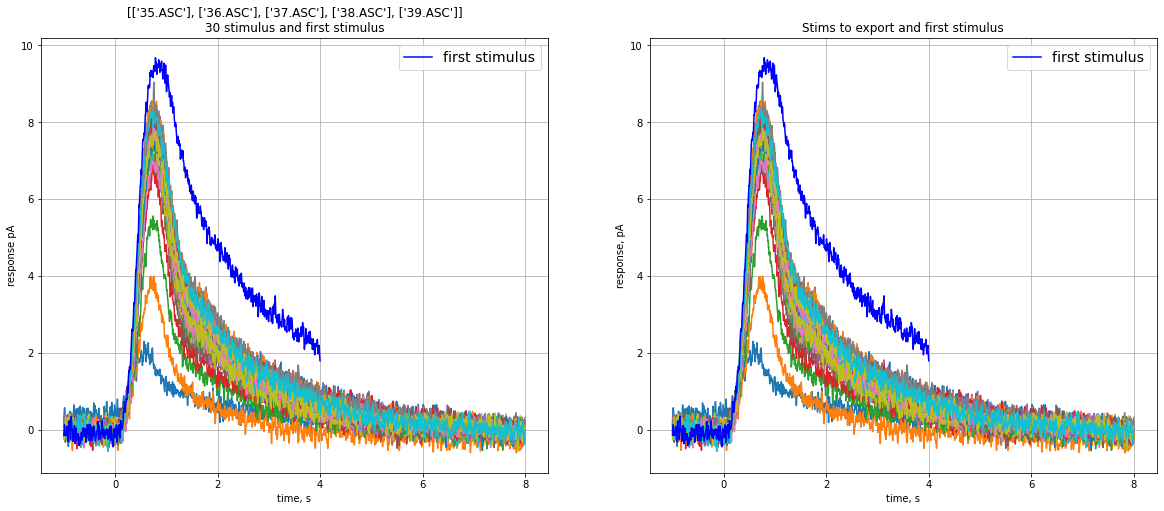

In [309]:
# Выделение стимулов и вычитание тренда из стимулов

stims = []

# вычитание экспоненты из первых stims_on_exp_cnt стимулов
for i in range(stims_on_exp_cnt):
    begin = (stims_t[i] - 1) * fs
    end = begin + (period + 1) * fs
    begin1 = (stims_t[i] - background_end_time - 1) * fs
    end1 = begin1 + (period  + 1) * fs
    stim = np.array(signal[begin:end] - exponent[begin1:end1])
    stims.append(stim)

# вычитание линейного тренда из остальных стимулов
prefix = fs # 1 секунда слева от стимула используется для расчета тренда
postfix = fs # последняя секунда стимула используется для расчета тренда
size = period * fs + prefix
for i in range(stims_on_exp_cnt, stims_cnt):
    begin = stims_t[i] * fs - prefix
    end = begin + size
    stim = np.array(signal[begin:end])
    temp_t = np.linspace(0, (size - 1), size)
    x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
    y = np.concatenate([stim[:prefix], stim[size - postfix:]])
    s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
    k, b = s[1], s[0]
    trend = k * temp_t + b
    stim = stim - trend
    stims.append(stim)

# Первый (опорный) стимул без вычитания тренда
begin = (first_stim_start_time - 1) * fs
end = background_start_time * fs
first_stim = np.array(signal[begin:end])
first_stim_max = first_stim.max()
first_stim_time_to_peak = first_stim.argmax() / fs - 1

size = (period + 1) * fs
temp_t = np.linspace(-1, period - 1 / fs, size)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
for stim in stims:
    ax1.plot(temp_t, stim)
end = background_start_time * fs
ax1.plot(temp_t[:end], first_stim, 'b', label='first stimulus')
ax1.legend(prop={"size": 14})
ax1.set_xlabel('time, s')
ax1.set_ylabel('response ' + signal_unit)
ax1.set_title(f'{filenames}\n{stims_cnt} stimulus and first stimulus')
ax1.grid()

numbers = set()
if not stims_to_export:
    numbers = set(range(stims_cnt))
else:
    for number in stims_to_export:
        if type(number) is tuple:
            numbers |= set(range(number[0], min(number[1] + 1, stims_cnt)))
        else:
            if number < stims_cnt:
                numbers.add(number)
stims_to_export = list(sorted(numbers))

for number in stims_to_export:
    ax2.plot(temp_t, stims[number])
end = background_start_time * fs
ax2.plot(temp_t[:end], first_stim, 'b', label='first stimulus')
ax2.legend(prop={"size": 14})
ax2.set_xlabel('time, s')
ax2.set_ylabel('response, ' + signal_unit)
ax2.set_title('Stims to export and first stimulus')
ax2.grid()

In [310]:
# Аппроксимация максимумов стимулов и времен до пика экспонентой
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

times_to_peak = np.zeros(stims_cnt)
stims_maximums = np.zeros(stims_cnt)
for i, stim in enumerate(stims):
     pos = stim.argmax()
     times_to_peak[i] = pos / fs - 1
     stims_maximums[i] = stim[pos]

# Считается расстояние между началом первого импульса после фоновой засветки и ее концом
# Графики максимумов стимулов и времен до пика начинают строиться в точке, равной рассчитанному расстоянию
stims_t -= background_end_time

print('Номер\tВремя\tМаксимум\tВремя до пика')
for i, (x, stim_maximum, time_to_peak) in enumerate(zip(stims_t, stims_maximums, times_to_peak)):
    print(f'{i}\t{x}\t{stim_maximum:.4f}\t{time_to_peak:.3f}')


Номер	Время	Максимум	Время до пика
0	8	2.3026	0.566
1	16	3.9998	0.756
2	24	5.5645	0.744
3	32	6.9331	0.748
4	40	7.4212	0.762
5	48	7.4291	0.720
6	56	7.5729	0.772
7	64	7.6401	0.770
8	72	7.7393	0.752
9	80	7.5877	0.754
10	88	7.8163	0.766
11	96	7.9717	0.832
12	104	7.6311	0.756
13	112	7.8990	0.820
14	120	8.5542	0.712
15	128	8.1043	0.752
16	136	7.1463	0.826
17	144	9.0426	0.754
18	152	7.6373	0.712
19	160	7.9476	0.758
20	168	7.7103	0.732
21	176	8.5416	0.806
22	184	8.2415	0.724
23	192	8.2861	0.782
24	200	8.1237	0.746
25	208	8.0513	0.748
26	216	7.8739	0.746
27	224	8.4533	0.768
28	232	7.7742	0.790
29	240	8.3340	0.728


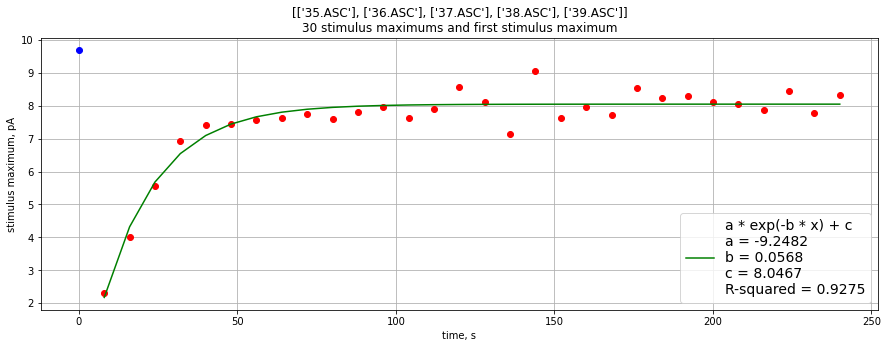

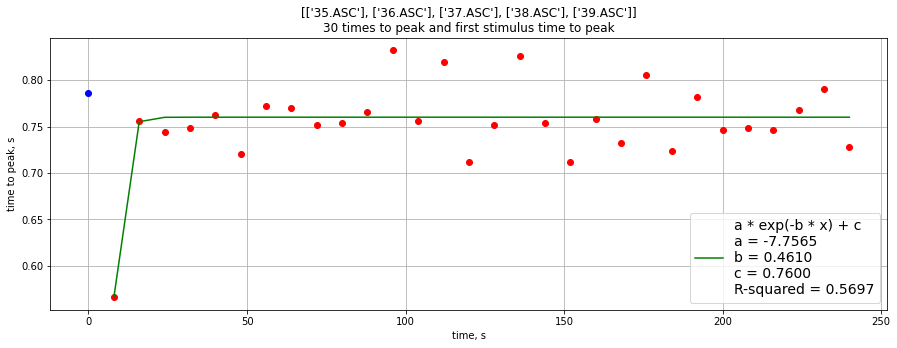

In [311]:
# Удаление неудачных стимулов
stims_maximums = np.delete(stims_maximums, stims_to_delete)
times_to_peak = np.delete(times_to_peak, stims_to_delete)
stims_t = np.delete(stims_t, stims_to_delete)

# Аппроксимация максимумов стимулов
popt = (1, 1, 1)
try:
    popt, pcov = optimize.curve_fit(func, stims_t, stims_maximums, [-10, 0.05, 10])
except RuntimeError:
    print('Не удалось выполнить аппроксимацию максимумов стимулов. Подберите начальные коэффициенты.')
exp_a1 = popt[0]
exp_b1 = popt[1]
exp_c1 = popt[2]
fit1 = func(stims_t, *popt)
rvalue1 = stats.linregress(stims_maximums, fit1).rvalue
r_squared1 = rvalue1 ** 2

# Аппроксимация времен до пика
popt = (1, 1, 1)
try:
    popt, pcov = optimize.curve_fit(func, stims_t, times_to_peak, [-10, 0.05, 10])
except RuntimeError:
    print('Не удалось выполнить аппроксимацию времен до пика. Подберите начальные коэффициенты.')
exp_a2 = popt[0]
exp_b2 = popt[1]
exp_c2 = popt[2]
fit2 = func(stims_t, *popt)
rvalue2 = stats.linregress(times_to_peak, fit2).rvalue
r_squared2 = rvalue2 ** 2

# Построение графика экспоненты максимумов стимулов
fig, ax = plt.subplots()
ax.plot(stims_t, stims_maximums, 'ro')
ax.plot(0, first_stim_max, 'bo')
ax.plot(stims_t, fit1, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {exp_a1:.4f}\n'
                           f'b = {exp_b1:.4f}\n'
                           f'c = {exp_c1:.4f}\n'
                           f'R-squared = {r_squared1:.4f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('stimulus maximum, ' + signal_unit)
ax.set_title(f'{filenames}\n{stims_maximums.size} stimulus maximums and first stimulus maximum')
ax.legend(prop={"size": 14})
ax.grid()

# Построение графика экспоненты времен до пика
fig, ax = plt.subplots()
ax.plot(stims_t, times_to_peak, 'ro')
ax.plot(0, first_stim_time_to_peak, 'bo')
ax.plot(stims_t, fit2, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {exp_a2:.4f}\n'
                           f'b = {exp_b2:.4f}\n'
                           f'c = {exp_c2:.4f}\n'
                           f'R-squared = {r_squared2:.4f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('time to peak, s')
ax.set_title(f'{filenames}\n{times_to_peak.size} times to peak and first stimulus time to peak')
ax.legend(prop={"size": 14})
ax.grid()

In [312]:
# Сохранение результатов в файлы
from pathlib import Path

Path(outputdir).mkdir(parents=True, exist_ok=True)
# Сохранение максимумов стимулов и времен до пика
with open(f'{outputdir}{filenames}_out.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{filenames}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write('\n')
    file.write(f'Максимумы стимулов - параметр экспоненты a\t{exp_a1:.4f}\n')
    file.write(f'Максимумы стимулов - параметр экспоненты b\t{exp_b1:.4f}\n')
    file.write(f'Максимумы стимулов - параметр экспоненты c\t{exp_c1:.4f}\n')
    file.write(f'Максимумы стимулов - постоянная времени 1/b\t{1 / exp_b1:.4f}\n')
    file.write(f'Максимумы стимулов - R-squared\t{r_squared1:.4f}\n')
    file.write('\n')
    file.write(f'Время до пика - параметр экспоненты a\t{exp_a2:.4f}\n')
    file.write(f'Время до пика - параметр экспоненты b\t{exp_b2:.4f}\n')
    file.write(f'Время до пика - параметр экспоненты c\t{exp_c2:.4f}\n')
    file.write(f'Время до пика - постоянная времени 1/b\t{1 / exp_b2:.4f}\n')
    file.write(f'Время до пика - R-squared\t{r_squared2:.4f}\n')
    file.write('\n')
    file.write('time, с\tU, у.е\tМаксимумы стимулов (a * exp(-b * x) + c)\ttime_to_peak, с\tВремя до пика (a * exp(-b * x) + c)\n')
    file.write(f'{0}\t{first_stim_max:.4f}\t\t{first_stim_time_to_peak:.3f}\t\n')
    for i in range(stims_maximums.size):
        file.write(f'{stims_t[i]}\t{stims_maximums[i]:.4f}\t{fit1[i]:.4f}\t{times_to_peak[i]:.3f}\t{fit2[i]:.3f}\n')

# Сохранение стимулов
with open(f'{outputdir}{filenames}_resp.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{filenames}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write('\n')
    file.write('time, с\tОпорный\t')
    for number in stims_to_export:
        file.write(f'{number}\t')
    file.write('\n')
    size = (period + 1) * fs
    temp_t = np.linspace(-1, period - 1 / fs, size)
    for i in range(size):
        file.write(f'{temp_t[i]:.3f}\t{first_stim[i] if i < first_stim.size else ""}\t')
        for number in stims_to_export:
            file.write(f'{stims[number][i]}\t')
        file.write('\n')